In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import random
import gc

In [2]:
device = torch.device('cuda')

In [3]:
path = Path("faces/")

In [4]:
files = path.ls(); files #predecir 8 numeros: 1 regresion, 2 clasificaciones

(#16738) [Path('faces/23_hola_mama_1_23016.jpg'),Path('faces/2_hola_papa_1_59613.jpg'),Path('faces/58_adios_mama_0_37692.jpg'),Path('faces/29_hola_perro_1_30941.jpg'),Path('faces/21_hola_mama_1_22430.jpg'),Path('faces/3_puercoespin_papa_1_34258.jpg'),Path('faces/38_hola_papa_1_20760.jpg'),Path('faces/30_adios_gato_0_32371.jpg'),Path('faces/75_puercoespin_papa_0_23752.jpg'),Path('faces/16_puercoespin_perro_0_34845.jpg')...]

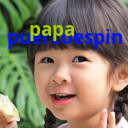

In [5]:
fv.PILImage.create(files[5])

In [6]:
caras = fv.get_image_files("faces/")
caras[0]

Path('faces/23_hola_mama_1_23016.jpg')

Edad, {hola, adiós puercoespín}, {papá, mamá, gato o perro}. Entonces el modelo debe sacar 8 números: la edad y la probabilidad de que salga cada cosa de las que están entre corchetes. 

Crear mi propia función de pérdida L1/MSE para edad, y Binary Corss Entropy (with logits) para las de clasificación. Una hay que reescalarla porque, recordemos, la de pérdida de la edad es más grande. 

Ver 3 métricas distintas: L1 en edad, accuracy en las otras 2 mientras los entreno. 

Ayuda: para pasar datablock: (ImageBlock,RegressionBlock,ClassificationBlock,ClassificationBlock) y n_inp=1 (para decirle a fastai que entra 1 y salen los otros 3).

In [7]:
#Para obtener las categorías:

def get_edad(x):
    return float(x.name.split("_")[0])
def get_first(x):
    return x.name.split("_")[1]
def get_second(x):
    return x.name.split("_")[2]

In [8]:
#Procediendo con los dataload

def load_data(folder, img_size,batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             do_flip = False, #se muere el letrero
                             flip_vert = False, 
                             max_rotate=10,
                             max_lighting=0.25,
                             max_zoom=1.3,
                             max_warp=0.2)
    
    data = fv.DataBlock(blocks     = (fv.ImageBlock, fv.RegressionBlock, fv.CategoryBlock, fv.CategoryBlock),
                         n_inp      = 1,
                         get_items  = fv.get_image_files,
                         get_y      = [get_edad,get_first,get_second],
                         splitter   = fv.RandomSplitter(0.08),
                         item_tfms  = fv.Resize(int(1.5*img_size)),
                         batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [36]:
data = load_data(path,img_size=224,batch_size=128)

In [38]:
data.one_batch()

(TensorImage([[[[8.6684e-01, 8.6903e-01, 8.6903e-01,  ..., 7.8821e-01,
            7.8821e-01, 7.8989e-01],
           [8.6656e-01, 8.6903e-01, 8.6903e-01,  ..., 7.8821e-01,
            7.8821e-01, 7.9010e-01],
           [8.6867e-01, 8.6903e-01, 8.6903e-01,  ..., 7.8821e-01,
            7.8821e-01, 7.8895e-01],
           ...,
           [7.3665e-01, 7.1942e-01, 7.0699e-01,  ..., 4.5030e-02,
            4.9225e-02, 4.9225e-02],
           [7.3153e-01, 7.1117e-01, 6.8740e-01,  ..., 4.4607e-02,
            4.9225e-02, 5.1151e-02],
           [7.0122e-01, 7.0674e-01, 6.8386e-01,  ..., 4.4607e-02,
            4.8767e-02, 4.9225e-02]],
 
          [[8.5147e-01, 8.4935e-01, 8.4935e-01,  ..., 7.5293e-01,
            7.5293e-01, 7.5466e-01],
           [8.5186e-01, 8.4935e-01, 8.4935e-01,  ..., 7.5293e-01,
            7.5293e-01, 7.5487e-01],
           [8.5469e-01, 8.4935e-01, 8.4935e-01,  ..., 7.5293e-01,
            7.5293e-01, 7.5370e-01],
           ...,
           [7.2212e-01, 7.0331e-0

In [10]:
data.one_batch()[0].shape

torch.Size([128, 3, 224, 224])

In [11]:
data.one_batch()[1].shape

torch.Size([128])

In [12]:
data.one_batch()[2]

TensorCategory([1, 1, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 2, 0,
        2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 2,
        1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0,
        1, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1,
        2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
        2, 0, 1, 2, 2, 2, 2, 1], device='cuda:0')

In [41]:
data.one_batch()[3]

TensorCategory([2, 2, 2, 1, 1, 0, 0, 2, 0, 3, 1, 0, 0, 3, 3, 3, 0, 3, 1, 1, 0, 1, 3, 3,
        1, 1, 2, 1, 2, 1, 2, 0, 1, 3, 0, 2, 0, 2, 3, 1, 1, 3, 3, 0, 3, 1, 3, 0,
        0, 0, 0, 3, 3, 1, 3, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 3, 3, 1, 0, 1, 0, 1,
        2, 0, 3, 0, 1, 1, 0, 1, 3, 0, 1, 1, 0, 1, 0, 3, 2, 0, 1, 3, 0, 1, 2, 1,
        0, 0, 0, 2, 2, 3, 3, 3, 2, 0, 2, 2, 3, 1, 3, 2, 3, 0, 1, 1, 3, 0, 3, 2,
        3, 3, 3, 0, 2, 3, 3, 3], device='cuda:0')

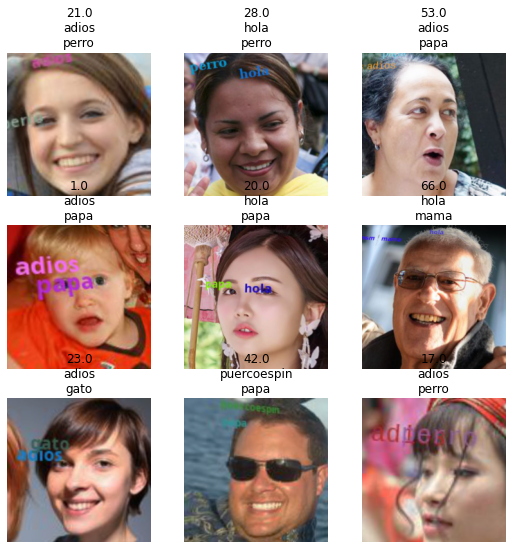

In [13]:
data.show_batch()

In [48]:
layers = list( fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(),nn.Linear(512,8)] #ya no es a 8, porque son 8 probabilidades


Pero las probabilidades 2,3 y 4 tienen que sumar 1, la 5, 6, 7 y 8 también entre ellas. El primer número es otro. Entonces, tengo que pasarle a las funciones su respectivo vector.

In [43]:
model = nn.Sequential(*layers)

In [44]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [17]:
model(torch.rand(1,3,128,128))

tensor([[ 0.1916,  0.2735,  0.2055, -0.5871, -0.6438,  0.5416, -0.6818, -0.4836]],
       grad_fn=<AddmmBackward>)

In [49]:
#___________Pero verlo va a estar más difícil
def loss_funct(pred, age, first, second):
    #print([a.shape for a in args])
    #raise
    pred_age = pred[:,0]
    pred_first = pred[:,1:4]
    pred_second = pred[:,4:]
    return F.mse_loss(pred_age,age)/20 + F.cross_entropy(pred_first,first)+F.cross_entropy(pred_second,second)


In [50]:
learner1 = fv.Learner(data, model, loss_func=loss_funct)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.010964781977236271)

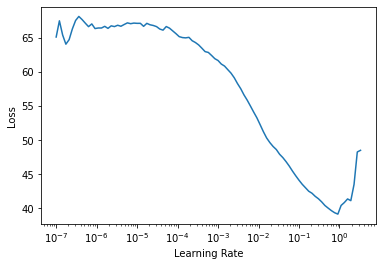

In [51]:
learner1.lr_find()

In [55]:
learner1.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,12.607025,6.629400,00:47


In [107]:
#____________Metricas
def age(yp,age,first, second):
    return F.l1_loss(yp[:,0],age)/20

def first(yp, age, first,second):
    return F.cross_entropy(yp[:,1:4], first)

def second(yp, age, first, second):
    return F.cross_entropy(yp[:,4:], second)

metrics = [age,first,second]

In [57]:
class Normalizer(nn.Module): #Del código del multiclass en Amazonas
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s
    
def my_splitter(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [78]:
def create_model():
    layers = [Normalizer()]
    layers += list(fv.resnet18(pretrained=True).children())[:-1]
    layers += [fv.Flatten(), nn.Linear(512,8)]
    #head = fv.create_head(1024,8,ps=0.4) #This thingy me estaba dando problemas... idk why i thought this was actually a good idea :()
    #head[5] = nn.LeakyReLU()
    #layers += list(head)
    model = nn.Sequential(*layers)
    return (model)

In [96]:
gc.collect()

27499

In [108]:
def create_learner(data,model, **kwargs):
    learner = fv.Learner(data, model,opt_func=fv.ranger, splitter=my_splitter, **kwargs)
    learner.freeze()
    return (learner)

In [109]:
model = create_model()

In [110]:
learner = create_learner(data, model, metrics=metrics ,loss_func=loss_funct)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.02754228748381138)

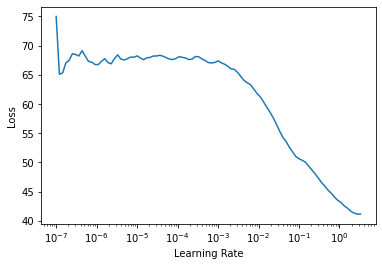

In [111]:
learner.lr_find()

In [112]:
learner.fit_one_cycle(5, lr_max=2.7e-2)

epoch,train_loss,valid_loss,age,first,second,time
0,12.228523,5.901433,0.292943,0.977585,1.585545,00:41
1,6.606370,6.337794,0.340463,0.666088,1.422635,00:41
2,4.846766,4.140140,0.233676,0.627702,1.388088,00:41
3,3.853292,3.386545,0.198697,0.506484,1.378504,00:41
4,3.328601,3.295024,0.194046,0.480323,1.366075,00:41


Debería seguir entrenando porque la valid_loss sigue bajando. Como la edad estaba con L1 y lo otro con Cross Entropy: al menos en la edad no lo está haciendo tan mal, aún deja qué desear en mamá, papá y puercoespín, la verdad. 

In [119]:
learner.unfreeze()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=6.309573450380412e-07)

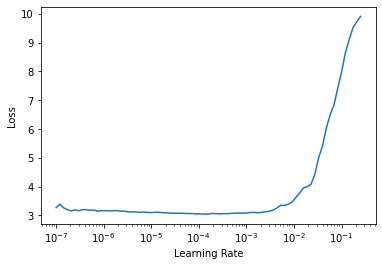

In [120]:
learner.lr_find() #esto se ve terrible

In [121]:
learner.fit_one_cycle(5, lr_max=1e-7)

epoch,train_loss,valid_loss,age,first,second,time
0,3.125071,3.245596,0.190792,0.483684,1.364839,00:47
1,3.159591,3.231930,0.190105,0.484035,1.364700,00:46
2,3.141345,3.341842,0.196864,0.484859,1.364402,00:47
3,3.133832,3.238209,0.190263,0.480208,1.365919,00:46
4,3.108299,3.250100,0.191100,0.481415,1.365144,00:46


In [123]:
import matplotlib as mpl
def show_results(self, max_n=16):
    dl = self.dls.valid.new(shuffle=True)
    x,y,z = dl.one_batch()
    yp = self.model(x).view(-1) 
    ctx = fv.get_grid(max_n) 
    for i in range(max_n):
        fv.show_image(x[i], ctx=ctx[i], title=f"{yp[i]:.1f} | {int(y[i])} (delta = {y[i]- yp[i]:.1f})\r  ") 

In [124]:
learner.validate()

(#4) [3.2500998973846436,0.19110047817230225,0.48141518235206604,1.3651442527770996]

En la edad lo está haciendo muy bien y también lo hace decente en la primera categoría. 